=== RESULTADOS CARREGADOS ===
{'mean_gmm': 0.4895476155079829, 'mean_hmm': 0.5107816388450319, 'std_gmm': 0.04378819273094049, 'std_hmm': 0.05215601724615223, 'gmm_fold_results': [0.5154639175257731, 0.42454954954954954, 0.4410810810810811, 0.4676767676767677, 0.45726495726495725, 0.47023086269744835, 0.522673031026253, 0.4913151364764268, 0.5747549019607843, 0.5304659498207885], 'hmm_fold_results': [0.5578465063001146, 0.5101351351351351, 0.5005405405405405, 0.5181818181818182, 0.5192307692307693, 0.4775212636695018, 0.40930787589498807, 0.45781637717121587, 0.5526960784313726, 0.6045400238948626]}


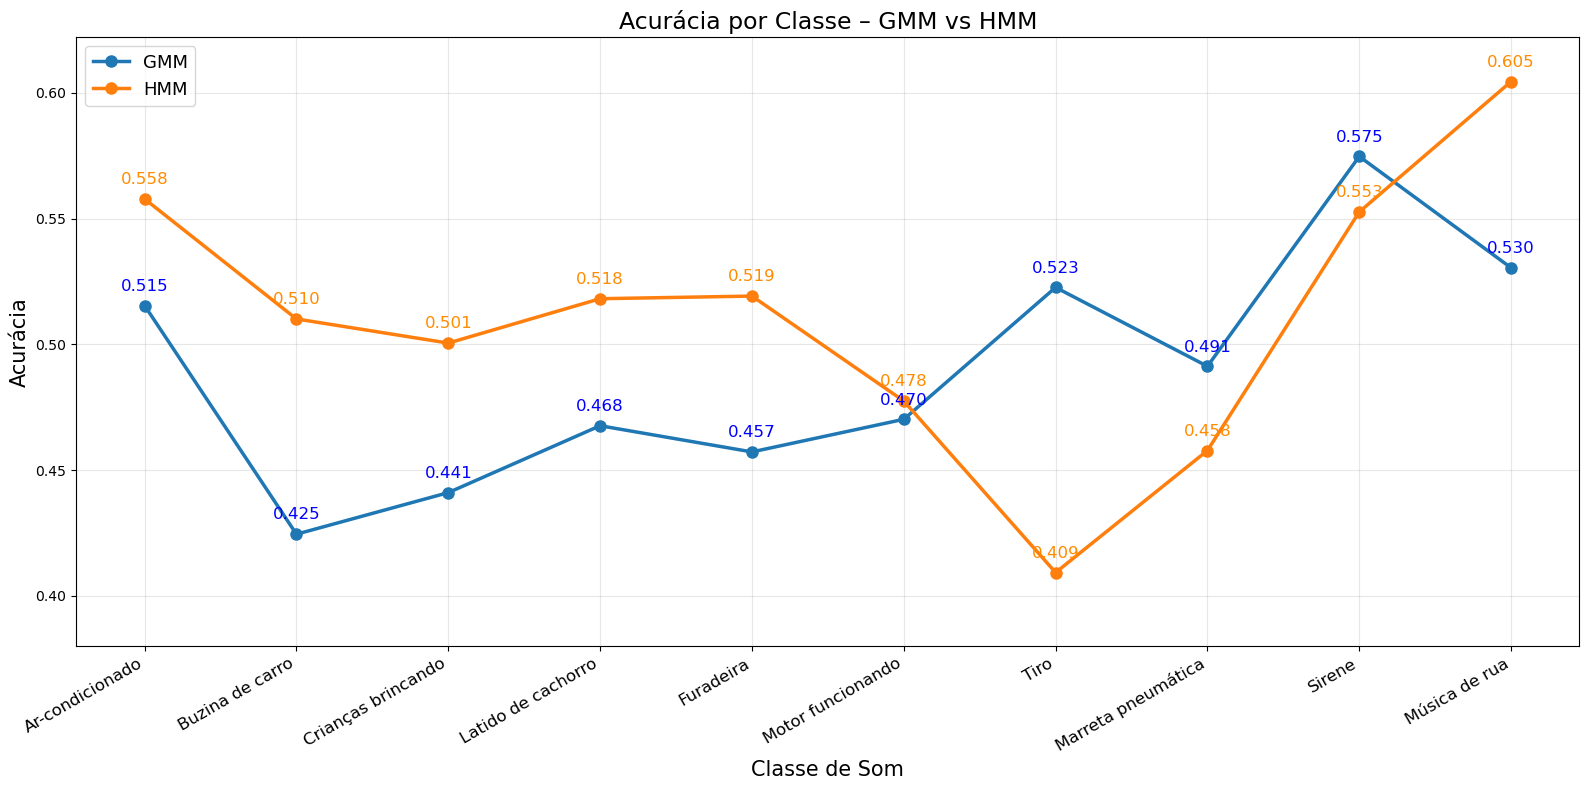

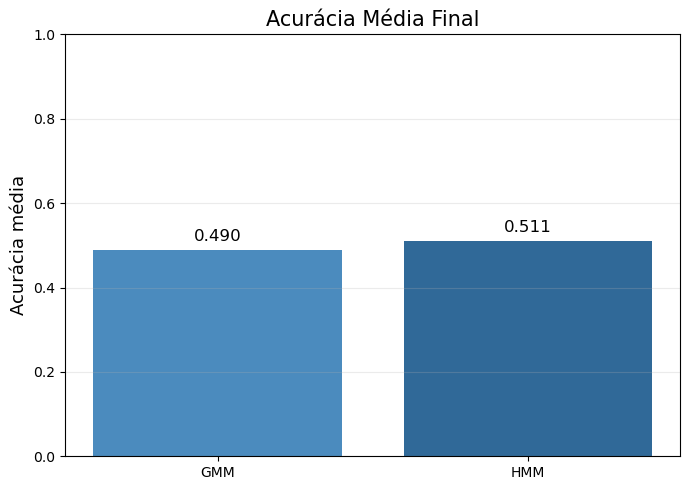

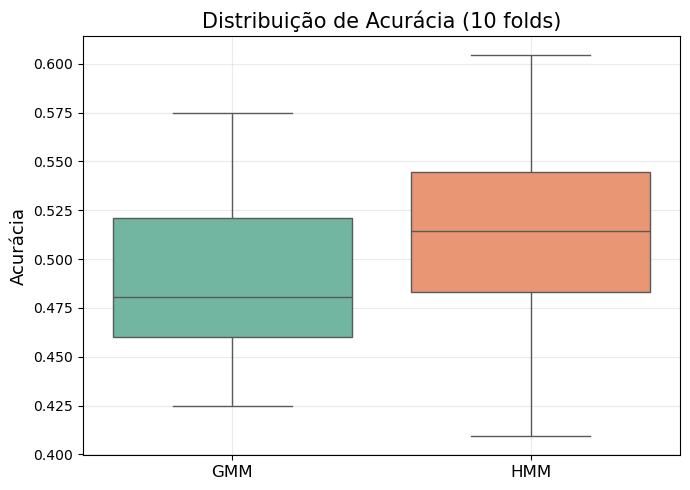

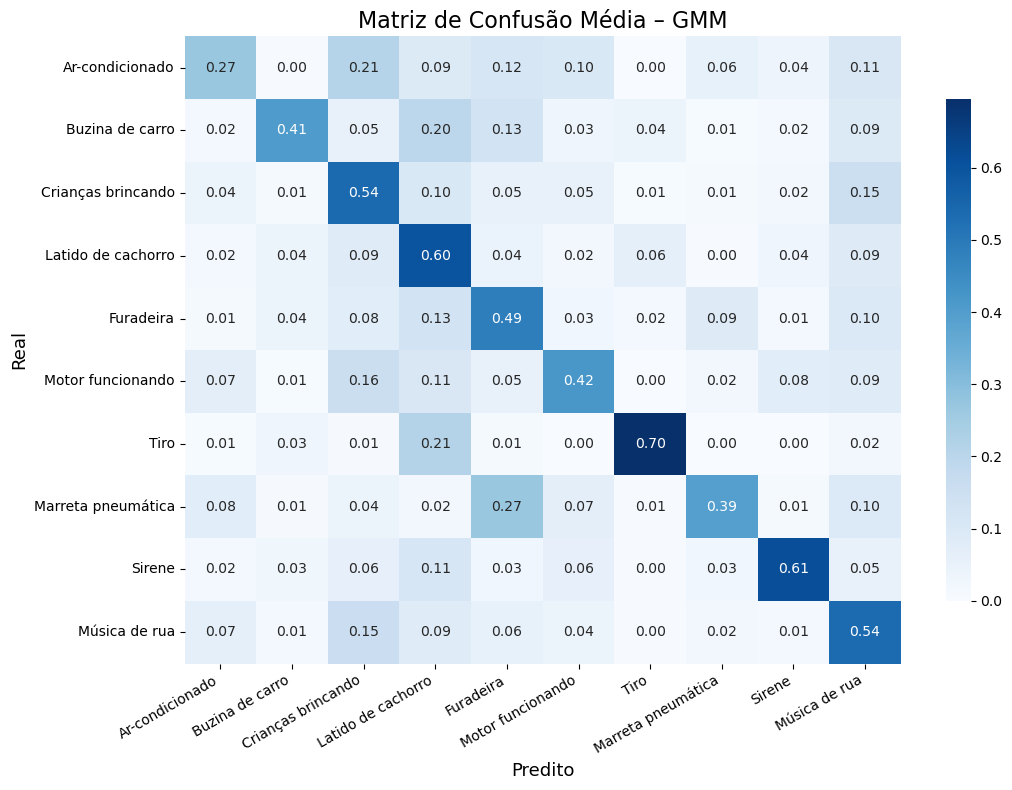

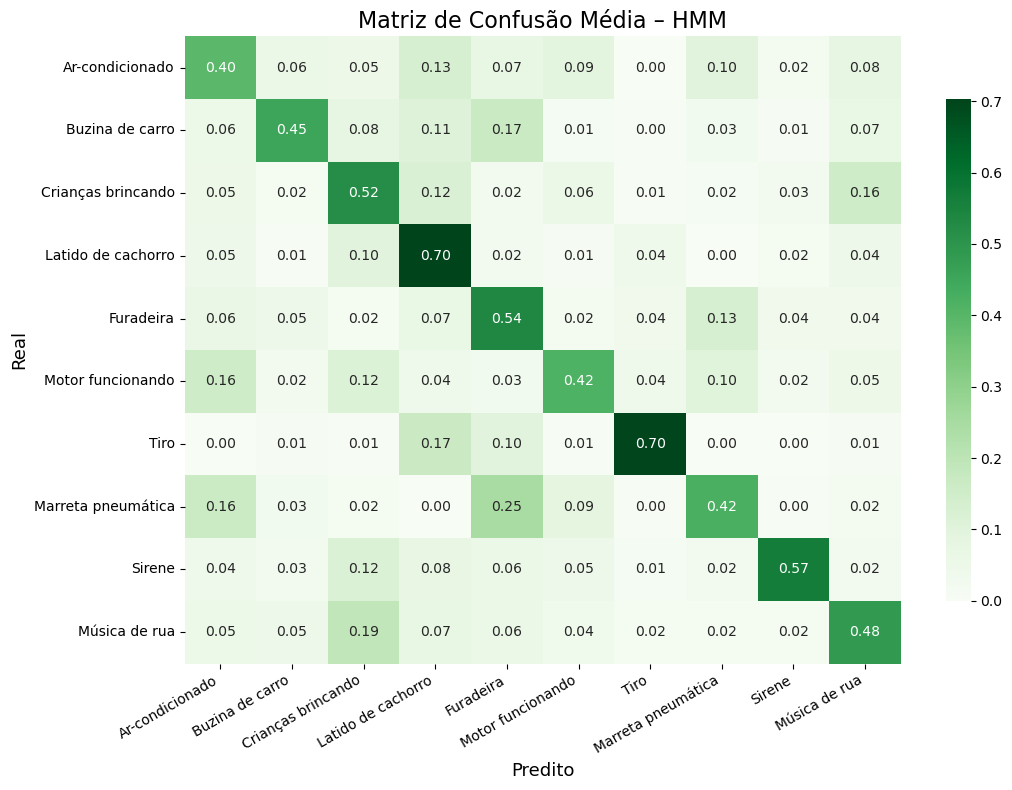


Todas as figuras foram exportadas para:
e:\ExameEET\results\figs


In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ============================
# CONFIGURAÇÃO
# ============================

base_path = os.getcwd()

results_path = os.path.join(base_path, "results")
output_path = os.path.join(results_path, "figs")

os.makedirs(output_path, exist_ok=True)

# Classes traduzidas
class_labels = [
    "Ar-condicionado",
    "Buzina de carro",
    "Crianças brincando",
    "Latido de cachorro",
    "Furadeira",
    "Motor funcionando",
    "Tiro",
    "Marreta pneumática",
    "Sirene",
    "Música de rua"
]

# ============================
# LEITURA DOS RESULTADOS
# ============================
gmm_acc = np.load(os.path.join(results_path, "gmm_fold_accuracy.npy"))
hmm_acc = np.load(os.path.join(results_path, "hmm_fold_accuracy.npy"))

with open(os.path.join(results_path, "summary.json"), "r") as f:
    summary = json.load(f)

print("=== RESULTADOS CARREGADOS ===")
print(summary)


# =====================================
# 1) ACURÁCIA POR CLASSE – (ANTES: FOLD)
# =====================================
plt.figure(figsize=(16, 8))

plt.plot(class_labels, gmm_acc, marker='o', linewidth=2.5, markersize=8, label="GMM")
plt.plot(class_labels, hmm_acc, marker='o', linewidth=2.5, markersize=8, label="HMM")

# Cálculo de deslocamento inteligente
offset = (max(max(gmm_acc), max(hmm_acc)) - min(min(gmm_acc), min(hmm_acc))) * 0.03

for i, v in enumerate(gmm_acc):
    plt.text(i, v + offset, f"{v:.3f}", ha='center', fontsize=12, color='blue')

for i, v in enumerate(hmm_acc):
    plt.text(i, v + offset, f"{v:.3f}", ha='center', fontsize=12, color='darkorange')

# Aumenta limite superior para evitar corte
plt.ylim(0.38, max(max(gmm_acc), max(hmm_acc)) + offset * 3)

plt.title("Acurácia por Classe – GMM vs HMM", fontsize=17)
plt.xlabel("Classe de Som", fontsize=15)
plt.ylabel("Acurácia", fontsize=15)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=13)
plt.tight_layout()

# =====================================
# 2) ACURÁCIA MÉDIA (BARRAS)
# =====================================
plt.figure(figsize=(7, 5))

means = [np.mean(gmm_acc), np.mean(hmm_acc)]
labels = ["GMM", "HMM"]
colors = ["#4B8BBE", "#306998"]

bars = plt.bar(labels, means, color=colors)
plt.ylim(0, 1)
plt.title("Acurácia Média Final", fontsize=15)
plt.ylabel("Acurácia média", fontsize=13)
plt.grid(alpha=0.25, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.02,
             f"{height:.3f}",
             ha='center',
             fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_path, "02_acuracia_media.png"), dpi=300)
plt.show()


# =====================================
# 3) BOXPLOT DOS 10 FOLDS
# =====================================
plt.figure(figsize=(7, 5))
sns.boxplot(data=[gmm_acc, hmm_acc], palette="Set2")

plt.xticks([0, 1], ["GMM", "HMM"], fontsize=12)
plt.title("Distribuição de Acurácia (10 folds)", fontsize=15)
plt.ylabel("Acurácia", fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()

plt.savefig(os.path.join(output_path, "03_boxplot.png"), dpi=300)
plt.show()


# =====================================
# 4) MATRIZ DE CONFUSÃO MÉDIA
# =====================================
num_classes = 10
cm_gmm_sum = np.zeros((num_classes, num_classes))
cm_hmm_sum = np.zeros((num_classes, num_classes))

for fold in range(1, 11):
    y_true = np.load(os.path.join(results_path, f"y_test_fold{fold}.npy"))
    gmm_pred = np.load(os.path.join(results_path, f"gmm_preds_fold{fold}.npy"))
    hmm_pred = np.load(os.path.join(results_path, f"hmm_preds_fold{fold}.npy"))

    cm_gmm_sum += confusion_matrix(y_true, gmm_pred, labels=range(num_classes))
    cm_hmm_sum += confusion_matrix(y_true, hmm_pred, labels=range(num_classes))

# Normalização por linha
cm_gmm_norm = cm_gmm_sum / cm_gmm_sum.sum(axis=1, keepdims=True)
cm_hmm_norm = cm_hmm_sum / cm_hmm_sum.sum(axis=1, keepdims=True)


# ----- Plot GMM -----
plt.figure(figsize=(11, 8))
sns.heatmap(cm_gmm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={"shrink": 0.8})

plt.title("Matriz de Confusão Média – GMM", fontsize=16)
plt.xlabel("Predito", fontsize=13)
plt.ylabel("Real", fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(os.path.join(output_path, "04_confusion_matrix_gmm.png"), dpi=300)
plt.show()


# ----- Plot HMM -----
plt.figure(figsize=(11, 8))
sns.heatmap(cm_hmm_norm,
            annot=True,
            fmt=".2f",
            cmap="Greens",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={"shrink": 0.8})

plt.title("Matriz de Confusão Média – HMM", fontsize=16)
plt.xlabel("Predito", fontsize=13)
plt.ylabel("Real", fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(os.path.join(output_path, "05_confusion_matrix_hmm.png"), dpi=300)
plt.show()

print("\nTodas as figuras foram exportadas para:")
print(output_path)
